In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy
import sklearn
from sklearn.preprocessing import MinMaxScaler as sc
import talib

import math
import os
import datetime

import warnings; warnings.simplefilter('ignore')


In [2]:
cols = ['date_time', 'open', 'high', 'low', 'close', 'volume']
patt1 = '/Users/justinsimcock/data/securities_data/hkx/' 
patt2 = 'DAT_ASCII_HKXHKD_M1_{year}.csv'
dfs = []
for y in range(2010,2019):
     dfs.append(pd.read_csv(patt1 + patt2.format(year=y), sep=';', header=-1, names = cols))

#concat dfs into one
hkx = pd.concat(dfs, axis=0)

In [3]:
len(hkx)

1230126

In [4]:
hkx.isnull().any()

date_time    False
open         False
high         False
low          False
close        False
volume       False
dtype: bool

In [5]:
hkx.head()

,date_time,open,high,low,close,volume
0,20101115 012600,24190.0,24190.0,24190.0,24190.0,0
1,20101115 013200,24173.0,24177.0,24168.0,24168.0,0
2,20101115 013300,24164.0,24172.0,24161.0,24161.0,0
3,20101115 013400,24159.0,24159.0,24141.0,24143.0,0
4,20101115 013500,24142.0,24142.0,24127.0,24131.0,0


In [6]:
hkx['date_time'] =  hkx['date_time'].apply(lambda x: datetime.datetime.strptime(x, '%Y%m%d %H%M%S'))
hkx = hkx.set_index('date_time')

In [7]:
hkx.isnull().any()

open      False
high      False
low       False
close     False
volume    False
dtype: bool

In [8]:
hkx_daily = hkx.close.resample('1D').ohlc()
hkx_daily = hkx_daily.dropna()

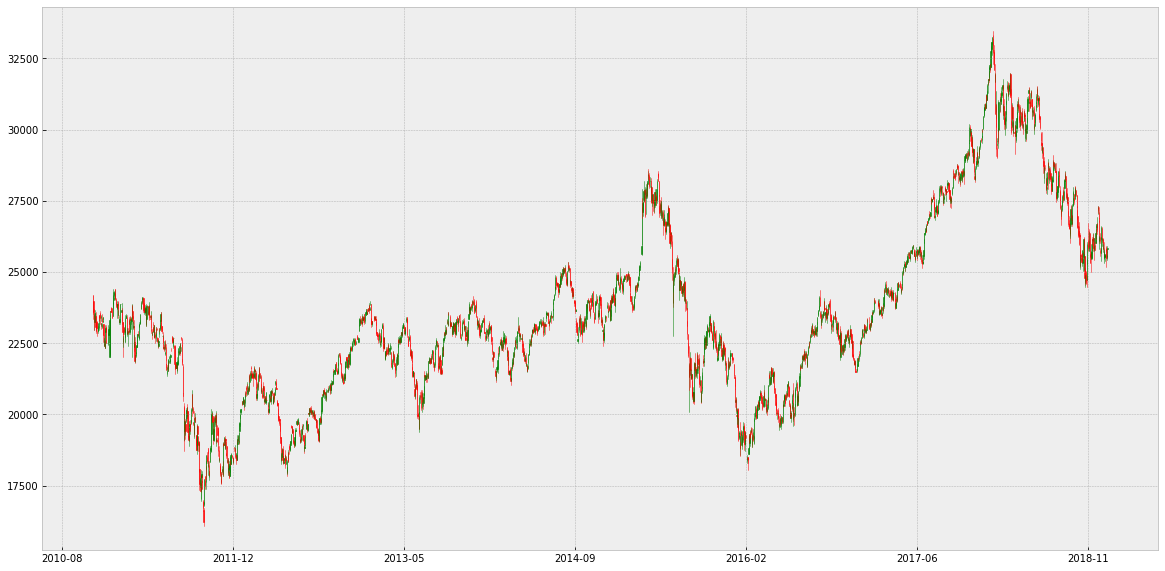

In [15]:
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates

import plotly.plotly as py
import plotly.graph_objs as go
from matplotlib import style
style.use('bmh')

f1, ax = plt.subplots(figsize = (20,10))

hkx_daily['date_time'] = mdates.date2num(hkx_daily.index.to_pydatetime())

ohlc = hkx_daily[['date_time', 'open', 'high', 'low','close']].copy()

candlestick_ohlc(ax, ohlc.values, width=.6, colorup='green', colordown='red')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

hkx_daily = hkx_daily.drop(columns='date_time')

In [16]:
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df.close.values.reshape(-1,1))
    return df
hkx_daily_norm = hkx_daily.copy()
hkx_daily_norm = normalize_data(hkx_daily_norm)

In [17]:
hkx_daily_norm.head()

,open,high,low,close
date_time,,,,
2010-11-15,0.452492,0.446232,0.428639,0.455212
2010-11-16,0.439312,0.433074,0.439036,0.432921
2010-11-17,0.407860,0.404904,0.405482,0.426996
2010-11-18,0.410496,0.416806,0.405482,0.413387
2010-11-19,0.396597,0.415431,0.423145,0.431220


In [18]:
len(hkx_daily_norm)

2452

In [19]:
#Splitting the dataset into Train, Valid & test data 
valid_set_size_percentage = 10 
test_set_size_percentage = 10 
seq_len = 20 # taken sequence length as 20
def load_data(stock, seq_len):
    data_raw = stock.as_matrix() 
    data = [] 
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

In [22]:
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(hkx_daily_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1946, 19, 4)
y_train.shape =  (1946, 4)
x_valid.shape =  (243, 19, 4)
y_valid.shape =  (243, 4)
x_test.shape =  (243, 19, 4)
y_test.shape =  (243, 4)


In [24]:
#Building the Model

# parameters & Placeholders 
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 200 
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

In [25]:
# function to get the next batch
index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

In [26]:
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size 
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size     
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

### Recurrent Neural Network

In [27]:
layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
         for layer in range(n_layers)]


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


### Short-term Memory Network

In [32]:
#LSTM  
layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
       for layer in range(n_layers)]

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


In [33]:
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence

In [34]:
# Cost function
loss = tf.reduce_mean(tf.square(outputs - y))

#optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)

In [35]:
# Fitting the model
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))
# Predictions
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    
#checking prediction output nos 
y_test_pred.shape

0.00 epochs: MSE train/valid = 0.071675/0.301121
4.98 epochs: MSE train/valid = 0.000651/0.001068
9.97 epochs: MSE train/valid = 0.000474/0.000704
14.95 epochs: MSE train/valid = 0.000474/0.000702
19.94 epochs: MSE train/valid = 0.000300/0.000385
24.92 epochs: MSE train/valid = 0.000239/0.000400
29.91 epochs: MSE train/valid = 0.000163/0.000138
34.89 epochs: MSE train/valid = 0.000148/0.000205
39.88 epochs: MSE train/valid = 0.000149/0.000245
44.86 epochs: MSE train/valid = 0.000122/0.000115
49.85 epochs: MSE train/valid = 0.000132/0.000202
54.83 epochs: MSE train/valid = 0.000123/0.000123
59.82 epochs: MSE train/valid = 0.000127/0.000232
64.80 epochs: MSE train/valid = 0.000144/0.000132
69.78 epochs: MSE train/valid = 0.000115/0.000122
74.77 epochs: MSE train/valid = 0.000113/0.000134
79.75 epochs: MSE train/valid = 0.000119/0.000118
84.74 epochs: MSE train/valid = 0.000122/0.000208
89.72 epochs: MSE train/valid = 0.000113/0.000110
94.71 epochs: MSE train/valid = 0.000129/0.000354
99.

(243, 4)

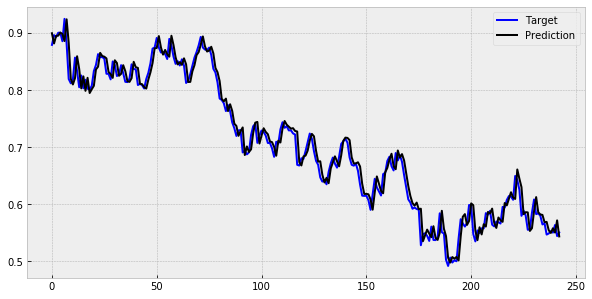

In [36]:
comp = pd.DataFrame({'Column1':y_test[:,3],'Column2':y_test_pred[:,3]})
plt.figure(figsize=(10,5))
plt.plot(comp['Column1'], color='blue', label='Target')
plt.plot(comp['Column2'], color='black', label='Prediction')
plt.legend()
plt.show()

In [ ]:
y_pred = y_test_pred[0]
y_pred = y_test_pred[0] > 0.5


dataset = df.copy()
dataset['y_pred'] = np.NaN
dataset.iloc[(len(dataset) - len(y_pred)):,-1:] = y_pred
trade_dataset = dataset.dropna()